In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import glob
import numpy as np
import editdistance
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr, kendalltau, rankdata
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
from math import ceil
import gzip
import pandas as pd
import time
import math
from sklearn.metrics.pairwise import pairwise_distances
import gzip

print(plt.style.available)
plt.style.use('seaborn-whitegrid')

['seaborn-colorblind', 'seaborn-dark-palette', 'bmh', 'seaborn-talk', 'seaborn-darkgrid', 'seaborn-dark', 'seaborn-bright', 'ggplot', 'seaborn-deep', '_classic_test', 'seaborn-ticks', 'seaborn-paper', 'classic', 'fivethirtyeight', 'seaborn-muted', 'seaborn', 'dark_background', 'seaborn-poster', 'grayscale', 'seaborn-white', 'seaborn-pastel', 'seaborn-whitegrid', 'seaborn-notebook']


# Embeddings visualisation

In [2]:
def compute_tau(emb_vec, seq_vec, SIZE=100000):
    vec_pairs = []
    vec_lev = []
    vec_dist = []
    np.random.seed(42)
    pair_indices = zip(np.random.choice(len(seq_vec), size=SIZE, replace=True), 
                       np.random.choice(len(seq_vec), size=SIZE, replace=True))
    pair_indices = set(pair_indices)

    to_remove = []
    for p1, p2 in pair_indices:
        if p1 == p2:
            to_remove.append((p1, p2))
    for val in to_remove:
        pair_indices.remove(val)

    for i,j in pair_indices:
        vec_pairs.append((i, j))
        vec_lev.append(editdistance.eval(seq_vec[i], seq_vec[j]))
        vec_dist.append(((emb_vec[i] - emb_vec[j]) ** 2).sum() ** .5)

    m, b = np.polyfit(vec_lev, vec_dist, 1)
    return vec_lev, vec_dist, m, b, kendalltau(vec_lev, vec_dist)


def plot_embed(folder_path, ax1, ax2, SIZE=100000):
    def _plot(file_path, ax, SIZE):
        seq_vec = []
        emb_vec = []
        try:
            with open(folder_path + "/" + file_path) as inp:
                for line in inp:
                    words = line.strip().split()
                    seq_vec.append(words[0])
                    emb_vec.append(list(map(float, words[1:])))
        except Exception:
            with gzip.open(folder_path + "/" + file_path + ".gz") as inp:
                for line in inp:
                    words = line.strip().split()
                    seq_vec.append(words[0])
                    emb_vec.append(list(map(float, words[1:])))
        emb_vec = np.array(emb_vec)
        print(folder_path, file_path)
        
#         vec_lev, vec_dist, m, b, tau = compute_tau(emb_vec, seq_vec, SIZE)
#         print(round(m, 3), round(b, 3), tau)

        x_values = np.array([i for i in range(18)])
#         ax.plot(rankdata(vec_lev, "ordinal"), rankdata(vec_dist, "ordinal"), '.')
#         ax.plot(x_values, x_values*m + b, '-')
        
        return emb_vec, [len(x) for x in seq_vec], seq_vec
        
    emb_tst, len_vec, seq_vec = _plot("embeddings_train.final.txt", ax1, SIZE)
#     emb_tst, len_vec, seq_vec = _plot("embeddings_test.final.txt", ax2, SIZE)
    
    return emb_tst, len_vec, seq_vec

# t-SNE

In [8]:
def plot_clusters(res, labels, ax, legend=False, psize=4, alpha=1):
    labels = np.array(labels)

    for uniq_len in set(labels):
        ax.scatter(res[labels==uniq_len,0], res[labels==uniq_len,1], label=uniq_len, s=psize, alpha=alpha)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1, Paired  
    colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]

    for t, j1 in enumerate(ax.collections):
        j1.set_color(colorst[t])

    if legend:
        ax.legend()
    

def plot_tsne(perplexity, ax, key, legend=False):
    embs, lens, seqs = emb_vecs[key]
    res = TSNE(perplexity=perplexity, n_jobs=4).fit_transform(embs)
    
    plot_clusters(res, lens, ax, legend)
    ax.set_title(key[key.find("/")+1:] + " | " + "perp. " + str(perplexity))
    
    return embs, res, seqs

# Loss visualisation

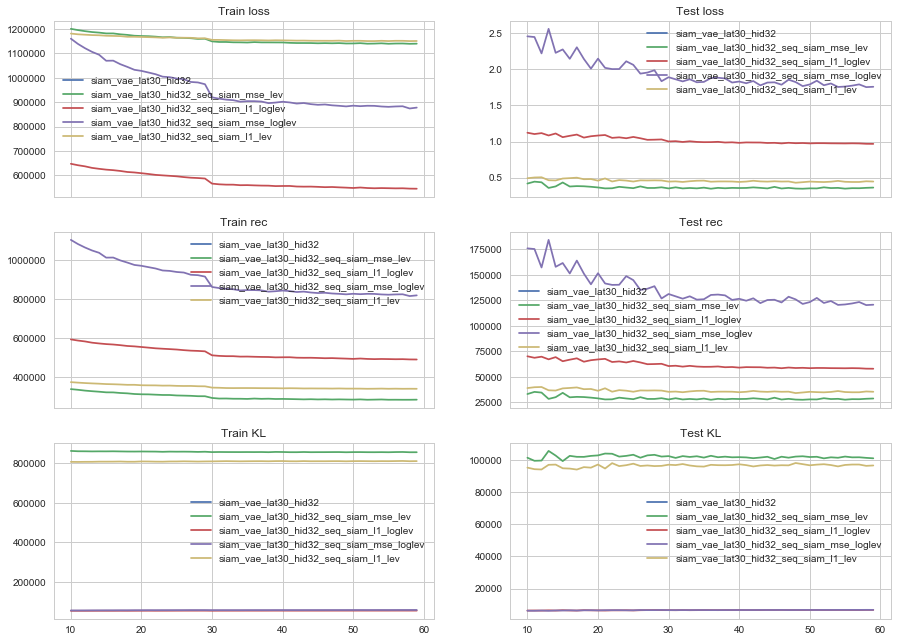

In [5]:
folders = glob.glob("results/siam_vae*")
log_dict = {}
for f in folders:
#     print(f)
    file_name = f[f.rfind("/")+1:]
    log_dict[file_name] = {}
    for f_log in glob.glob(f + "/log*"):
        key_name = f_log[f_log.rfind("/")+10:-4]
        log_dict[file_name][key_name] = [float(line.strip()) for line in open(f_log)]
        
        
num_rows = max(len(x.keys()) // 2 for x in log_dict.values())
fig, ax = plt.subplots(ncols=2, nrows=num_rows, sharex=True)

map_plot = {"train": (0,0), "test": (0,1), 
            "train_rec": (1,0), "test_rec": (1,1), 
            "train_kl": (2,0), "test_kl": (2,1)}

fig.set_size_inches((15,11))


START = 10

for folder in log_dict:
    for loss_type, val in log_dict[folder].items():
        ax[map_plot[loss_type]].plot([x for x in range(START, len(val))], val[START:], label=folder)
            
    
for i in range(3):
    ax[i][0].legend()
    ax[i][1].legend()
    
ax[0][0].set_title("Train loss")
ax[0][1].set_title("Test loss")
ax[1][0].set_title("Train rec")
ax[1][1].set_title("Test rec")
ax[2][0].set_title("Train KL")
ax[2][1].set_title("Test KL")

results/siam_words_norep_lay2_lat30_hid128_euc_w100l embeddings_train.final.txt
results/siam_words_norep_lay2_lat30_hid128_euc_w100n embeddings_train.final.txt
results/siam_words_norep_lay2_lat30_hid128_euc_w100s embeddings_train.final.txt
results/siam_words_norep_lay2_lat30_hid256_euc_w100l embeddings_train.final.txt
results/siam_words_norep_lay2_lat30_hid256_euc_w100n embeddings_train.final.txt
results/siam_words_norep_lay2_lat30_hid256_euc_w100s embeddings_train.final.txt


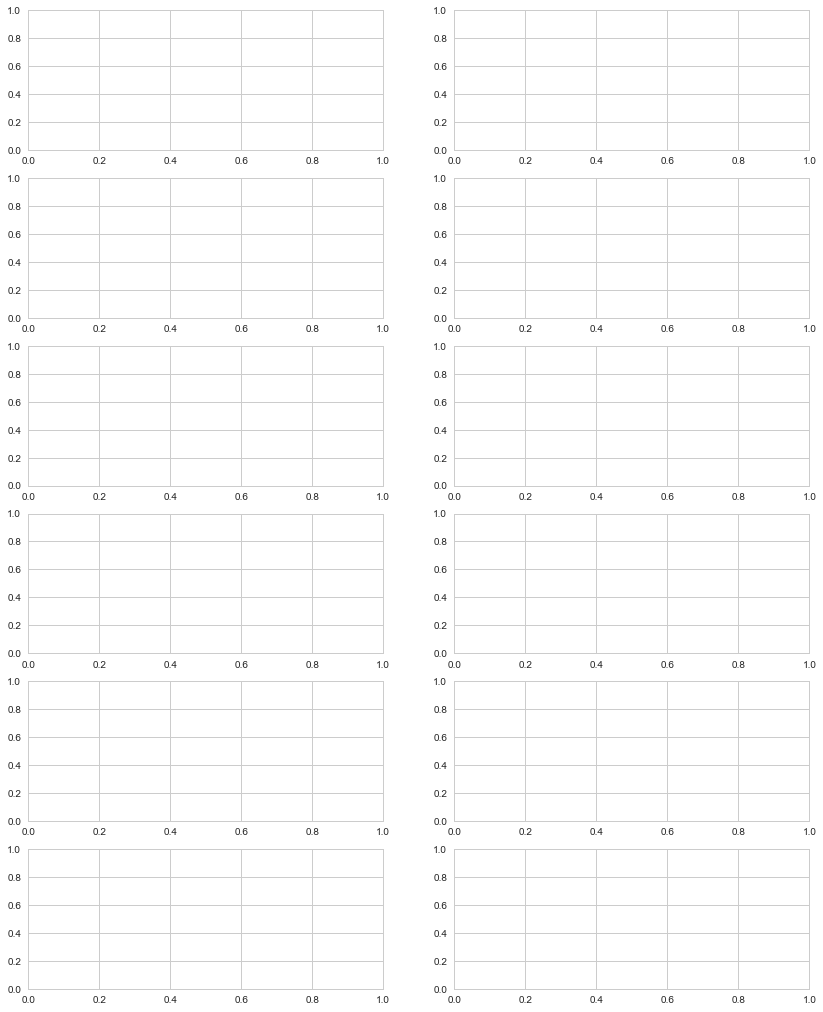

In [42]:
folder_path = glob.glob("results/siam*euc*")

# fig, ax = plt.subplots(len(folder_path), 2, sharex=True, sharey=True)
fig, ax = plt.subplots(len(folder_path), 2)
fig.set_figheight(3 * len(folder_path))
fig.set_figwidth(14)

emb_vecs = {}

SIZE = 50000
for i, f in enumerate(folder_path):
#     ax_sub = ax[i]
    ax_sub = ax
    emb_vecs[f] = plot_embed(f, ax_sub[0], ax_sub[1], SIZE)
#     ax_sub[0].set_title("Train | " + f)
#     ax_sub[1].set_title("Test")
    
# print(emb_vecs.keys())
# print(emb_vecs["results/wordsT/siam_nwords_norep_lat30_hid32"][0].shape)

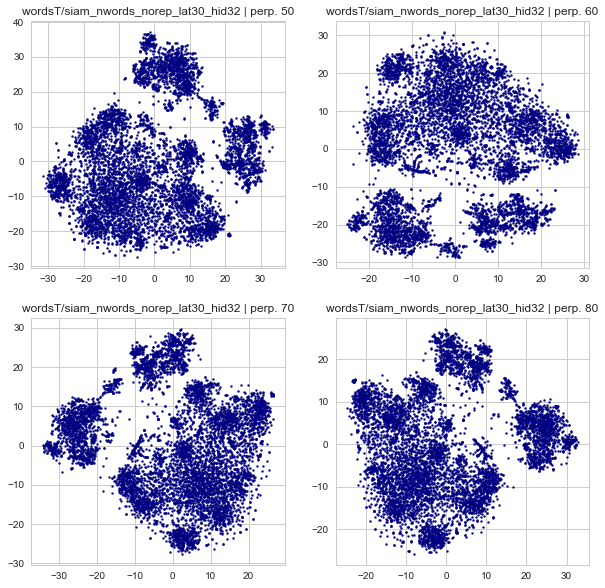

In [16]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)

storage = {}

# KEY = 'results/siam_svae_lat30_old'
# KEY = 'results/siam_svae_disb_rl1'
KEY = 'results/wordsT/siam_nwords_norep_lat30_hid32'
storage["1"] = plot_tsne(50, ax[0,0], KEY)

KEY = 'results/wordsT/siam_nwords_norep_lat30_hid32'
storage["2"] = plot_tsne(60, ax[0,1], KEY)

KEY = 'results/wordsT/siam_nwords_norep_lat30_hid32'
storage["3"] = plot_tsne(70, ax[1,0], KEY)

KEY = 'results/wordsT/siam_nwords_norep_lat30_hid32'
storage["4"] = plot_tsne(80, ax[1,1], KEY)

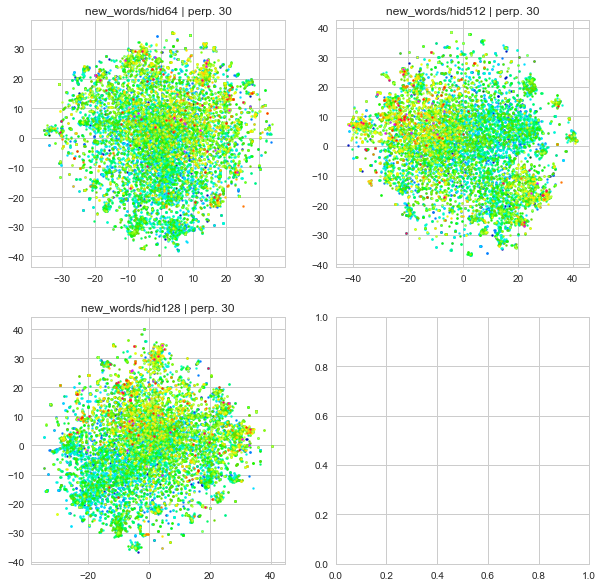

In [28]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)

storage = {}

KEY = 'results/new_words/hid64'
storage["1"] = plot_tsne(30, ax[0,0], KEY)

KEY = 'results/new_words/hid128'
storage["1"] = plot_tsne(30, ax[1,0], KEY)

KEY = 'results/new_words/hid512'
storage["1"] = plot_tsne(30, ax[0,1], KEY)

# storage["2"] = plot_tsne(50, ax[0,1], KEY)
# storage["3"] = plot_tsne(80, ax[1,0], KEY)
# storage["4"] = plot_tsne(100, ax[1,1], KEY)

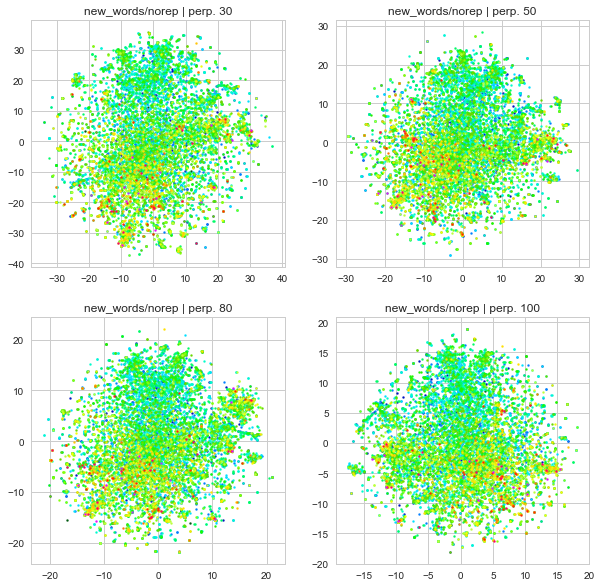

In [24]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)

storage = {}

KEY = 'results/new_words/norep'
storage["1"] = plot_tsne(30, ax[0,0], KEY)
storage["2"] = plot_tsne(50, ax[0,1], KEY)
storage["3"] = plot_tsne(80, ax[1,0], KEY)
storage["4"] = plot_tsne(100, ax[1,1], KEY)

In [35]:
emb_vecs.keys()

dict_keys(['results/siam_words_norep_lay2_lat30_hid128_euc_w100n', 'results/siam_words_norep_lay2_lat30_hid128_euc_w100s', 'results/siam_words_norep_lay2_lat30_hid128_euc_w100l'])

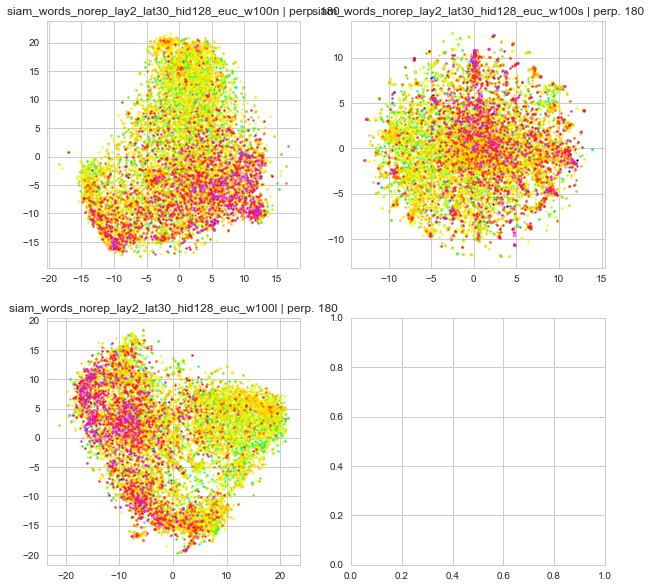

In [45]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)

storage = {}

# KEY = 'results/siam_svae_lat30_old'
# KEY = 'results/siam_svae_disb_rl1'
KEY = 'results/siam_words_norep_lay2_lat30_hid128_euc_w100n'
storage["1"] = plot_tsne(180, ax[0,0], KEY)

KEY = 'results/siam_words_norep_lay2_lat30_hid128_euc_w100s'
storage["2"] = plot_tsne(180, ax[0,1], KEY)

KEY = 'results/siam_words_norep_lay2_lat30_hid128_euc_w100l'
storage["3"] = plot_tsne(180, ax[1,0], KEY)

# KEY = 'results/wordsT/siam_nwords_norep_lat30_hid32'
# storage["4"] = plot_tsne(100, ax[1,1], KEY)

(array([  7.08000000e+02,   2.00000000e+00,   3.80000000e+01,
          3.00000000e+02,   2.72800000e+03,   3.13500000e+03,
          1.56100000e+03,   7.76000000e+02,   3.49000000e+02,
          1.69000000e+02,   1.02000000e+02,   5.60000000e+01,
          2.90000000e+01,   1.80000000e+01,   1.10000000e+01,
          5.00000000e+00,   6.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   4.00000000e+00]),
 array([ 0.        ,  0.03683637,  0.07367275,  0.11050912,  0.1473455 ,
         0.18418187,  0.22101824,  0.25785462,  0.29469099,  0.33152736,
         0.36836374,  0.40520011,  0.44203649,  0.47887286,  0.51570923,
         0.55254561,  0.58938198,  0.62621835,  0.66305473,  0.6998911 ,
         0.73672748]),
 <a list of 20 Patch objects>)

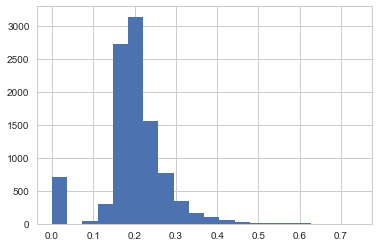

In [55]:
FILENAME = "words_euc/words_euc_100_sum.npz"
inds_vec = np.load(FILENAME)["inds10"]
old_mat = np.load(FILENAME)["matrix"]
res = []
for i in range(10000):
    res.append(pairwise_distances(old_mat[i].reshape((1, -1)), old_mat[inds_vec[i][1]].reshape((1, -1))))
old_dist = np.array(res).reshape((-1, 1))

plt.hist(old_dist, bins=20)

In [38]:
storage.keys()

dict_keys(['results/siam_svae_lat30_hid32_tsne_25', 'results/siam_svae_lat30_hid32_tsne_15', 'results/siam_svae_lat30_hid64_tsne_45', 'results/siam_svae_lat30_hid64_tsne_85'])

In [39]:
for KEY in storage:
    print(KEY)
    print(compute_tau(storage[KEY][1], storage[KEY][2], SIZE=50000)[4])

results/siam_svae_lat30_hid32_tsne_25
KendalltauResult(correlation=0.24527301889859329, pvalue=0.0)
results/siam_svae_lat30_hid32_tsne_15
KendalltauResult(correlation=0.27715716752931063, pvalue=0.0)
results/siam_svae_lat30_hid64_tsne_45
KendalltauResult(correlation=0.28054929608324303, pvalue=0.0)
results/siam_svae_lat30_hid64_tsne_85
KendalltauResult(correlation=0.30537650824594476, pvalue=0.0)


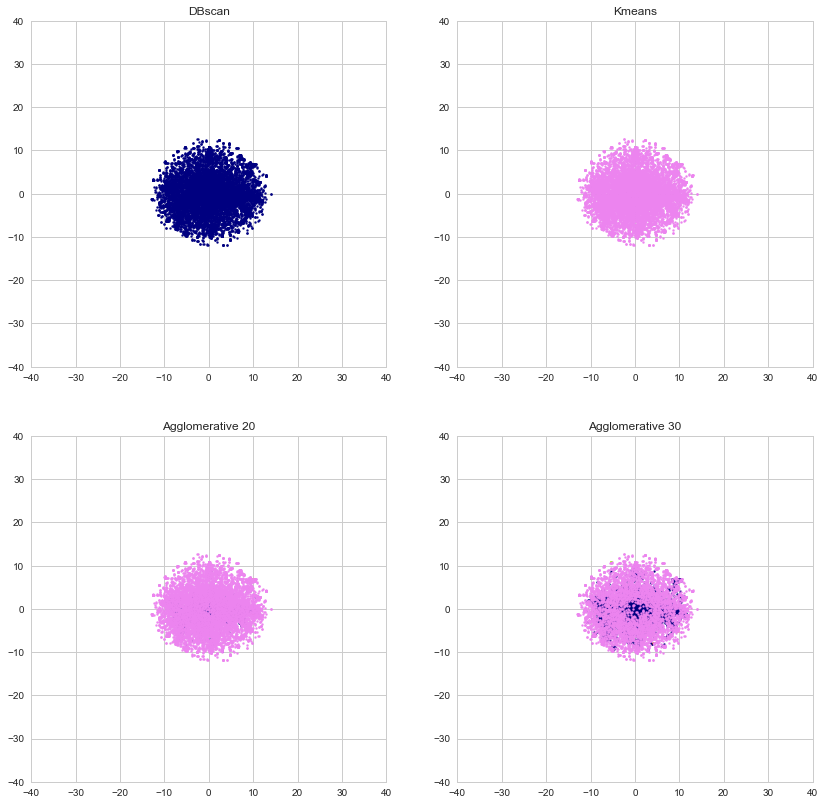

In [57]:
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AffinityPropagation, AgglomerativeClustering
from collections import Counter

# KEY = 'results/vae_lay3_lat20_300k_500_tsne_20'
KEY = '2'
# KEY = 'results/siam_svae_disb_rl1_tsne_80'
embeds, tsne_embeds, sequences = storage[KEY]

res_cl1 = DBSCAN(eps=.1, n_jobs=4).fit_predict(embeds)
res_cl2 = DBSCAN(eps=.15, n_jobs=4).fit_predict(embeds)
res_cl3 = DBSCAN(eps=.2, n_jobs=4).fit_predict(embeds)
res_cl4 = DBSCAN(eps=.25, n_jobs=4).fit_predict(embeds)

# res_cl1 = KMeans(40, n_jobs=4).fit_predict(tsne_embeds)
# res_cl2 = KMeans(60, n_jobs=4).fit_predict(tsne_embeds)
# res_cl3 = KMeans(80, n_jobs=4).fit_predict(tsne_embeds)
# res_cl4 = KMeans(100, n_jobs=4).fit_predict(tsne_embeds)

fig, ax = plt.subplots(2,2)
fig.set_figheight(14)
fig.set_figwidth(14)

plot_clusters(tsne_embeds, res_cl1, ax[0][0], legend=False)
plot_clusters(tsne_embeds, res_cl2, ax[0][1], legend=False)
plot_clusters(tsne_embeds, res_cl3, ax[1][0], legend=False)
plot_clusters(tsne_embeds, res_cl4, ax[1][1], legend=False)

for i in range(2):
    for j in range(2):
        ax[i][j].set_xlim([-40, 40])
        ax[i][j].set_ylim([-40, 40])

ax[0][0].set_title("DBscan")
ax[0][1].set_title("Kmeans")
ax[1][0].set_title("Agglomerative 20")
ax[1][1].set_title("Agglomerative 30")

(array([  5.43900000e+03,   4.51400000e+03,   1.40000000e+01,
          5.00000000e+00,   0.00000000e+00,   6.00000000e+00,
          6.00000000e+00,   7.00000000e+00,   5.00000000e+00,
          4.00000000e+00]),
 array([-1. , -0.2,  0.6,  1.4,  2.2,  3. ,  3.8,  4.6,  5.4,  6.2,  7. ]),
 <a list of 10 Patch objects>)

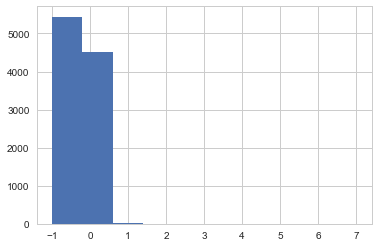

In [62]:
plt.hist(res_cl4)

In [91]:
sequences = np.load("words_euc/words_euc_100_sum.npz")["names"]

# sequences = np.array(sequences)
cluster_res = res_cl4
for clust_ind in set(cluster_res):
    if clust_ind != -1:
        subset = sequences[cluster_res == clust_ind]
        if len(subset) < 30:
            for x in sorted(subset):
                print(x)
            print()

АРИФМЕТИКА
БЕЗРУКАВКА
ЗАДАНИЕ
ЗЕРНЫШКО
ИЗБУШКА
ИЗВИНЕНИЕ
ИЗДАТЕЛЬ
КАУЧУК
КЛОК
ЛИС
ЛИЧИКО
МЕСТЬ
ОБУВЬ
ПОСЕЛЕНЕЦ
ПРЕДЛОГ
ПРЕДУБЕЖДЕНИЕ
ПРИМИРЕНИЕ
РЕШИМОСТЬ
СМЕСЬ
СОХРАНЕНИЕ
ТИП
ТРАВА
ЧЕПЕЦ
ШКВАЛ



In [141]:
def compute_psi(sequences, clusters):
    sequences = np.array(sequences)
    lev_dist = []
    sizes = []
    for clust_ind in set(clusters):
#         if (clust_ind+1) % 50 == 0:
#             print(clust_ind+1, "/", len(set(clusters)))
        if clust_ind != -1:
            subset = sequences[clusters == clust_ind]
            temp = []
            for i in range(len(subset) - 1):
                for j in range(i+1, len(subset)):
                    temp.append(editdistance.eval(subset[i], subset[j]))
#             temp_prop = max(ceil(len(temp) * .1), 5)
            temp_prop = len(subset)
            lev_dist.append(sum(sorted(temp)[:temp_prop]) / temp_prop)
            sizes.append(len(subset))
    return lev_dist, sizes
        
# lev_dist, sizes = compute_psi(sequences, res_cl1)
# sns.distplot(compute_psi(sequences, res_cl1), bins=20)

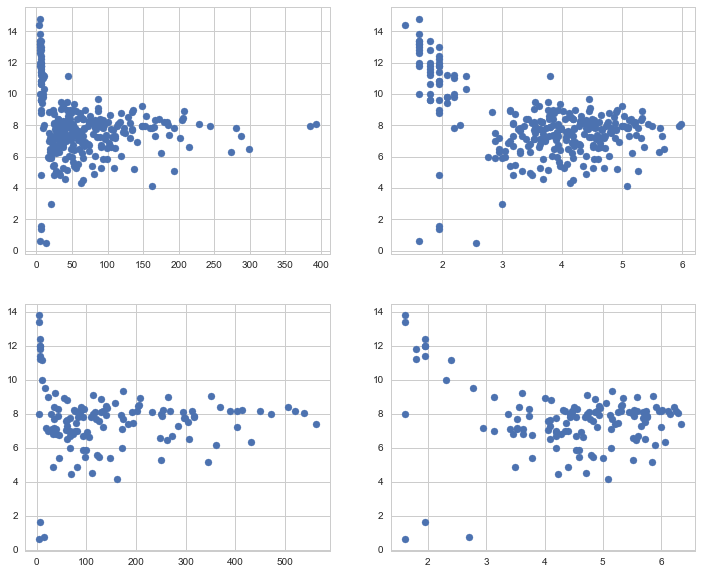

In [135]:
# 10%, tsne 15
fig, ax = plt.subplots(ncols=2, nrows=2)
fig.set_figwidth(12)
fig.set_figheight(10)

lev_dist, sizes = compute_psi(sequences, res_cl1)

ax[0][0].scatter(sizes, lev_dist)
ax[0][1].scatter(np.log(sizes), lev_dist)

lev_dist, sizes = compute_psi(sequences, res_cl4)

ax[1][0].scatter(sizes, lev_dist)
ax[1][1].scatter(np.log(sizes), lev_dist)

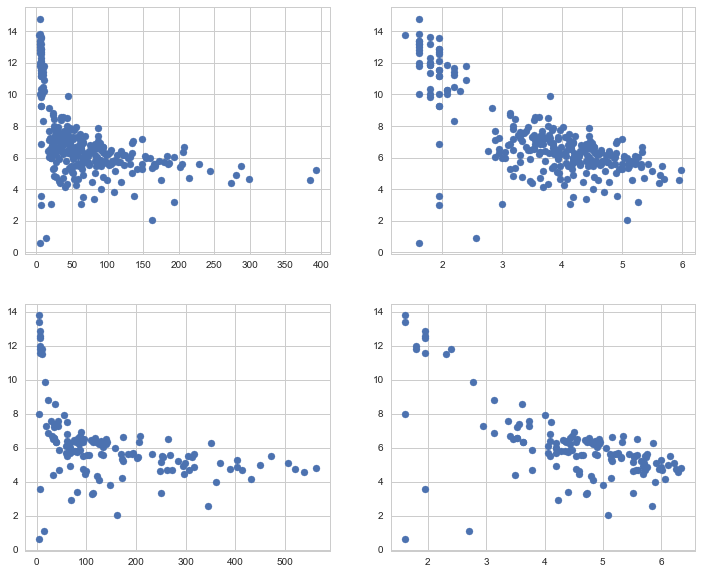

In [142]:
# 10%, TSNE 35

fig, ax = plt.subplots(ncols=2, nrows=2)
fig.set_figwidth(12)
fig.set_figheight(10)

lev_dist, sizes = compute_psi(sequences, res_cl1)

ax[0][0].scatter(sizes, lev_dist)
ax[0][1].scatter(np.log(sizes), lev_dist)

lev_dist, sizes = compute_psi(sequences, res_cl4)

ax[1][0].scatter(sizes, lev_dist)
ax[1][1].scatter(np.log(sizes), lev_dist)

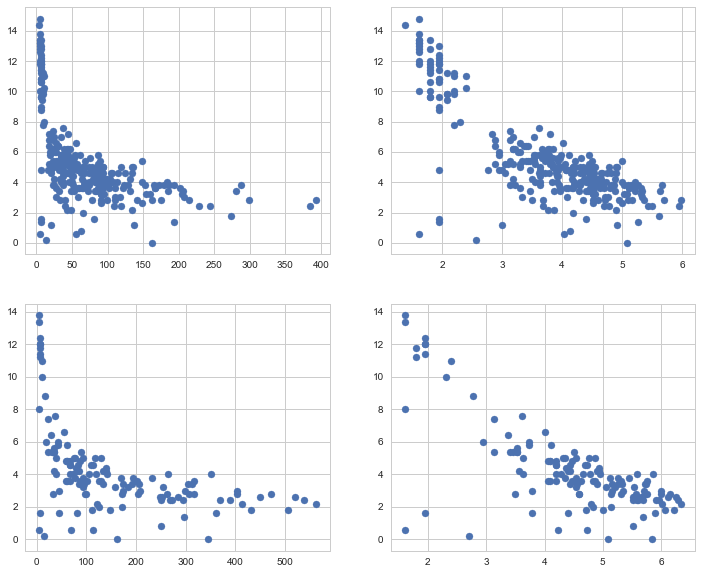

In [133]:
# 5, tsne 15
fig, ax = plt.subplots(ncols=2, nrows=2)
fig.set_figwidth(12)
fig.set_figheight(10)

lev_dist, sizes = compute_psi(sequences, res_cl1)

ax[0][0].scatter(sizes, lev_dist)
ax[0][1].scatter(np.log(sizes), lev_dist)

lev_dist, sizes = compute_psi(sequences, res_cl4)

ax[1][0].scatter(sizes, lev_dist)
ax[1][1].scatter(np.log(sizes), lev_dist)

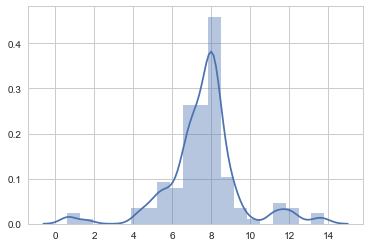

In [105]:
sns.distplot(compute_psi(sequences, res_cl4), bins=20)

In [100]:
eps_vec = np.linspace(.7, 1.2, 15)
mat = np.zeros((len(storage), len(eps_vec)))

for i, key in enumerate(storage):
    print(i)
    _, tsne_embeds, sequences = storage[key]
    
    for j, eps in enumerate(eps_vec):
        res_cl = DBSCAN(eps=eps_vec[j], n_jobs=4).fit_predict(tsne_embeds)
        lev_dist = compute_psi(sequences, res_cl)
        mat[i,j] = np.percentile(lev_dist, q=75)

0
1
2
3


In [ ]:
ax = sns.heatmap(mat.T, linewidths=.5, cmap="RdBu", 
            annot=True, yticklabels=eps_vec.round(2), 
            xticklabels=[key.split("_")[-1] for key in storage], 
                 square=False)

ax.set_title("Зависимость пси-коэффициента от значений eps и P")
ax.set_xlabel("P")
ax.set_ylabel("eps")

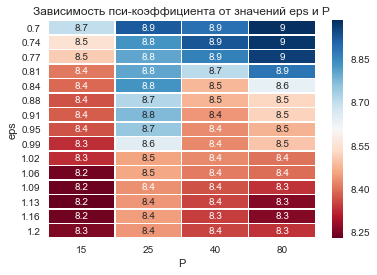

In [112]:
ax = sns.heatmap(mat.T, linewidths=.5, cmap="RdBu", 
            annot=True, yticklabels=eps_vec.round(2), 
            xticklabels=[key.split("_")[-1] for key in storage], 
                 square=False)

ax.set_title("Зависимость пси-коэффициента от значений eps и P")
ax.set_xlabel("P")
ax.set_ylabel("eps")

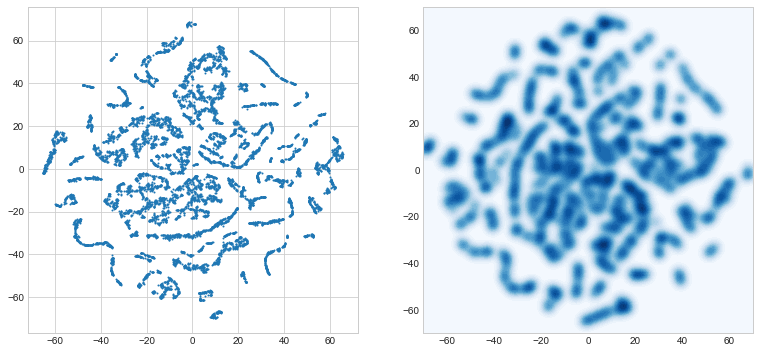

In [275]:
from sklearn.neighbors import KernelDensity

# 1.1. KDE on weighted by the number of sequences

# 2.1. clusterise DBSCAN
# 2.2. extract clusters of interest - clusters with many number of shared sequences, e.g., re-weight them by counts

fig, ax = plt.subplots(ncols = 2)
fig.set_figheight(6)
fig.set_figwidth(13)

kde = KernelDensity(bandwidth=2, kernel='gaussian').fit(tsne_embeds)

x = np.arange(-70,71)
y = np.arange(-70,71)

X,Y = np.meshgrid(x,y)
xy = np.vstack([Y.ravel(), X.ravel()]).T
Z = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

levels = np.linspace(0, Z.max(), 25)

ax[0].scatter(tsne_embeds[:,0], tsne_embeds[:,1], s=1)
ax[1].contourf(X, Y, Z, levels=levels, cmap=plt.cm.Blues)

# Графики для диссера

## Сравнение автоэнкодеров

In [ ]:
folder_path = glob.glob("disser_plots/compare_ae/*")

fig, ax = plt.subplots(len(folder_path), 2, sharex=True, sharey=True)
fig.set_figheight(3 * len(folder_path))
fig.set_figwidth(14)

emb_vecs = {}

SIZE = 50000
for i, f in enumerate(folder_path):
    ax_sub = ax[i]
    emb_vecs[f] = plot_embed(f, ax_sub[0], ax_sub[1], SIZE)
    ax_sub[0].set_title("Train | " + f)
    ax_sub[1].set_title("Test")

In [ ]:
fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)

storage = {}

KEY = 'disser_plots/compare_ae/AE'
storage[KEY] = plot_tsne(30, ax[0,0], KEY)

KEY = 'disser_plots/compare_ae/SAE'
storage[KEY] = plot_tsne(30, ax[0,1], KEY)

KEY = 'disser_plots/compare_ae/VAE'
storage[KEY] = plot_tsne(30, ax[1,0], KEY)

KEY = 'disser_plots/compare_ae/SVAE'
storage[KEY] = plot_tsne(30, ax[1,1], KEY)

In [ ]:
ax[0][0].set_title("Автокодировщик")
ax[0][0].set_xlim(-45, 45)
ax[0][0].set_ylim(-45, 46)

ax[0][1].set_title("Многослойный автокодировщик")
ax[0][1].set_xlim(-65, 65)
ax[0][1].set_ylim(-65, 65)

ax[1][0].set_title("Вариационный автокодировщик")
ax[1][0].set_xlim(-70, 70)
ax[1][0].set_ylim(-70, 70)

ax[1][1].set_title("Многослойный вариационный автокодировщик")
ax[1][1].set_xlim(-70, 70)
ax[1][1].set_ylim(-70, 70)

fig.savefig("chapter2_ae_test.png", dpi=400, pad_inches=.3, bbox_inches="tight")

## Эксп. 1. Пять лучших автоэнкодеров

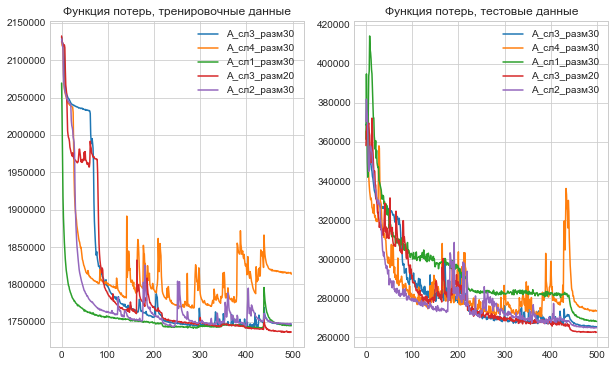

In [207]:
folders = glob.glob("disser_plots/best_ae/*")
log_dict = {}
for f in folders:
#     print(f)
    file_name = f[f.rfind("/")+1:]
    log_dict[file_name] = {}
    for f_log in glob.glob(f + "/log*"):
        key_name = f_log[f_log.rfind("/")+10:-4]
        log_dict[file_name][key_name] = [float(line.strip()) for line in open(f_log)]
        
        
fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True)

map_plot = {"train": (0,0), "test": (0,1), 
            "train_rec": (1,0), "test_rec": (1,1), 
            "train_kl": (2,0), "test_kl": (2,1)}

fig.set_size_inches((10,6))

for folder in log_dict:
    for loss_type, val in log_dict[folder].items():
        if loss_type == "train":
            ax[0].plot([x for x in range(len(val)-2)], val[2:], label=folder)
        elif loss_type == "test":
            ax[1].plot([x for x in range(len(val))], val, label=folder)
            

ax[0].legend()
ax[1].legend()
    
ax[0].set_title("Функция потерь, тренировочные данные")
ax[1].set_title("Функция потерь, тестовые данные")

fig.savefig("chapter2_ae_comp.png", dpi=400, pad_inches=.3, bbox_inches="tight")

## Эксп. 2. Анализ и визуализация репертуаров (левенштейн и кроссы)

In [173]:
def time_since(since):
    now = time.time()
    sec = now - since
    s = sec
    m = math.floor(sec / 60)
    s -= m * 60
    return '%dm%ds' % (m, s), sec

df1 = pd.read_csv("disser_data/A1.txt", index_col=0).reset_index()
df2 = pd.read_csv("disser_data/A2.txt")

print(len(df1))
print(len(df2))

184431
94824


In [193]:
df1 = pd.read_csv("disser_data/A1.txt", index_col=0).reset_index()
unique_seq = df1.loc[df1["proportion"] > df1["proportion"].min(), "cdr3aa"].unique()
print(len(unique_seq))
inds = np.random.permutation(120000)

with open("A1_train.txt", "w") as outf:
    outf.write("cdr3aa\n")
    for i in range(90000):
        outf.write(unique_seq[inds[i]] + '\n')
        
with open("A1_test.txt", "w") as outf:
    outf.write("cdr3aa\n")
    for i in range(90000, 120000):
        outf.write(unique_seq[inds[i]] + '\n')

122873


In [ ]:
df1 = pd.read_csv("disser_data/A1_train.txt", index_col=0).reset_index()
df2 = pd.read_csv("disser_data/A1_test.txt", index_col=0).reset_index()

In [197]:
df1 = pd.read_table("ignore/all.txt.gz", index_col=0).reset_index()
unique_seq = df1["cdr3aa"].unique()
print(len(unique_seq))
inds = np.random.permutation(1532875)

with open("Gen_train.txt", "w") as outf:
    outf.write("cdr3aa\n")
    for i in range(500000):
        outf.write(unique_seq[inds[i]] + '\n')
        
with open("Gen_test.txt", "w") as outf:
    outf.write("cdr3aa\n")
    for i in range(500000, 530000):
        outf.write(unique_seq[inds[i]] + '\n')

/Users/vdn/anaconda/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


1532875


In [ ]:
file_name = "A1_test"
df1 = pd.read_csv("results/inference/siam_inference_" + file_name + "/embeddings.txt", sep = " ", header=None)
np.savez_compressed(df1.values[:, 1:].astype(np.float32))

In [3]:
start = time.time()

for j in np.random.choice(30000, size = 100, replace=False):
    for i in range(30000):
        editdistance.eval(df1["cdr3aa"][j], df2["cdr3aa"][i])

fancy, LEV_TIME = time_since(start)
print(fancy)

2m28s


In [4]:
print("Время на построение маленькой матрицы расстояний", round(LEV_TIME, 2))

print("Время на построение полной матрицы расстояний", round(LEV_TIME * 300, 2))

print("Время на построение полной матрицы расстояний", round(LEV_TIME * 300 / 4, 2))

Время на построение маленькой матрицы расстояний 148.6
Время на построение полной матрицы расстояний 44580.23
Время на построение полной матрицы расстояний 11145.06


In [31]:
len(set(df1["cdr3aa"][:1000]).intersection(set(df2["cdr3aa"][:1000])))

47

In [5]:
30000 ** 2

900000000

In [21]:
184431 - sum(df1["proportion"] < 3.54590e-07)

145008

In [12]:
# a1_embed = pd.read_table("results/siam_inference_A1/embeddings.txt", header=None, sep=" ").values[:, 1:].astype(np.float64)
# a2_embed = pd.read_table("results/siam_inference_A2/embeddings.txt", header=None, sep=" ").values[:, 1:].astype(np.float64)

# Plos was made from this
# df1 = pd.read_table("results/siamese_local_model/siam_svae_lat30_hid64/embeddings_test.final.txt", header=None, sep=" ")
# df2 = pd.read_table("results/siamese_local_model/siam_svae_lat30_hid64/embeddings_test.final.txt", header=None, sep=" ")

filename = "disser_plots/experiment_3_2/inference/siam_inference_ae_lat30_hid32_mse_loglev/embeddings.npz"
df = np.load(filename)["emb"]
seq_names = np.load(filename)["seq"]

ind = np.random.choice(np.arange(20000), size=16000, replace=False)
ind_1 = ind[:8000]
ind_2 = ind[8000:]

a1_embed = df[ind_1, :].astype(np.float64)
a2_embed = df[ind_2, :].astype(np.float64)

a1_seq = seq_names[ind_1]
a2_seq = seq_names[ind_2]

# a1_embed = df1.values[ind_1, 1:].astype(np.float64)
# a2_embed = df2.values[ind_2, 1:].astype(np.float64)

# a1_embed = df1.values[:5000, 1:].astype(np.float64)
# a2_embed = df2.values[:5000, 1:].astype(np.float64)

print(a1_embed.shape)
print(a2_embed.shape)

(8000, 30)
(8000, 30)


In [13]:
import time

start_time = time.time()
tsne_a12 = TSNE(perplexity=80, n_jobs=-1).fit_transform(np.vstack([a1_embed, a2_embed]))
print(time.time() - start_time)

75.72986698150635


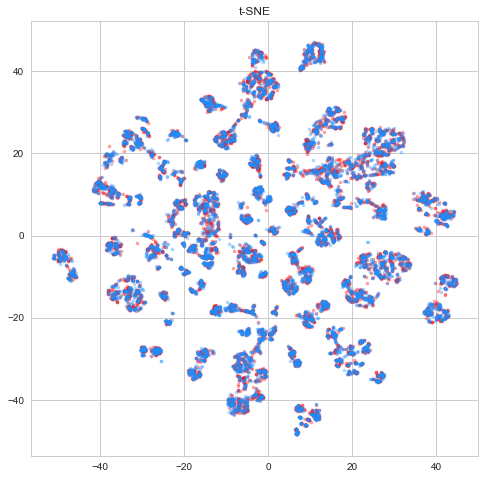

In [14]:
def plot_clusters2(res, labels, ax, legend=False, psize=4, alpha=1):
    labels = np.array(labels)

    for i, uniq_len in enumerate(set(labels)):
        ax.scatter(res[labels==uniq_len,0], res[labels==uniq_len,1], label=uniq_len, 
                   s=psize, alpha=alpha, color=["red", "dodgerblue"][i])

#     colormap = plt.cm.gist_ncar #nipy_spectral, Set1, Paired, gist_ncar 
# #     colorst = [colormap(i) for i in np.linspace(0, 0.9, len(ax.collections))]
#     colorst = [colormap(i) for i in np.linspace(0, 0.9, 20)]
#     colorst = [colorst[3]] + [colorst[15]]

#     for t, j1 in enumerate(ax.collections):
#         j1.set_color(colorst[t])

    if legend:
        ax.legend()
        

fig, ax = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(8)


plot_clusters2(tsne_a12, 
              np.hstack([["A1" for _ in range(a1_embed.shape[0])], ["A2" for _ in range(a2_embed.shape[0])]]), 
              ax,
              False, 
              10, alpha=.35)

ax.set_title("t-SNE")
# ax.set_xlim([-60, 60])
# ax.set_ylim([-60, 60])

(-60, 60)

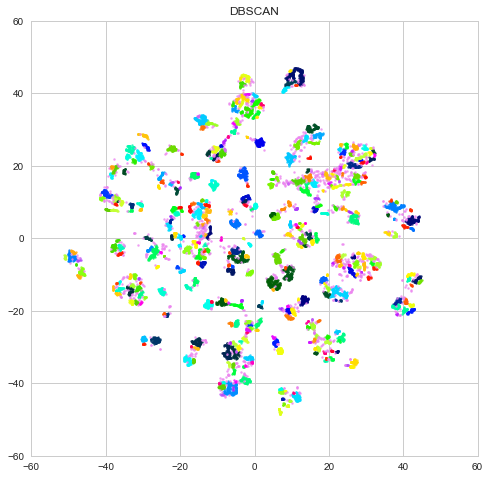

In [15]:
from sklearn.cluster import DBSCAN

res_cl1 = DBSCAN(eps=.4, n_jobs=-1).fit_predict(tsne_a12)

fig, ax = plt.subplots(1,1)
fig.set_figheight(8)
fig.set_figwidth(8)

plot_clusters(tsne_a12, res_cl1, ax, legend=False, alpha=.8)

ax.set_title("DBSCAN")
ax.set_xlim([-60, 60])
ax.set_ylim([-60, 60])

In [16]:
sequences = np.hstack([a1_seq, a2_seq])
for clust_ind in set(res_cl1):
    if clust_ind != -1:
        subset = sequences[res_cl1 == clust_ind]
        if len(subset) < 10:
            for x in sorted(subset):
                print(x)
            print("---")

CASSASDMHEKLFF$
CASSFGTVERAFF$
CASSLGTDPEKLFF$
CASSLSPRQTRFF$
CASSLVPDEKLFF$
CASSQGVVPPEKLFF$
CASSQRTATNEKLFF$
CASSQVEVEKLFF$
CASSSNRAGKLFF$
---
CASSFNKQGLFSYEQYF$
CASSGGQRSLPPYEQYF$
CASSQERTLWGKGSYEQYF$
CASSQHPGQSSYEQYF$
CASSQMTGRGASYEQYF$
CASSQTSGANYSYEQYF$
CASSQVRSGGVSYEQYF$
---
CASSFGLAGHSYEQYF$
CASSGTTGTEFSYEQYF$
CASSRRVGQSSSYEQYF$
CASSSILGTGSYEQYF$
CASSTWGLAGGLPSYEQYF$
---
CASCYGGGSNDEQFF$
CASGRGPSNEQFF$
CASIFLGTSNNEQFF$
CASITSGVSNEQFF$
CASREQGASRNEQFF$
CASRPLAGGSNEQFF$
CASRPTAASNEQFF$
CASRYTFASNEQFF$
---
CASSFRPGEGSEQYF$
CASSFRPGSHEQYF$
CASSPPGQGSHEQYF$
CASSPRGGSSEQYF$
CASSPSGQGLSEQYF$
CASSPTPPGQGSEQYF$
CASSPWKEGSDEQYF$
CASSSPLGSNEQYF$
CASSTPTGSHEQYF$
---
CASSGGAKDTQYF$
CASSGSFADTQYF$
CASSQDFADTQYF$
CASSQGWADTQYF$
CASSQYYADTQYF$
CASSSSVADTQYF$
CASSVVAHTQYF$
---
CAISESGDYNSPLHF$
CAISGTGGAYNSPLHF$
CAISLTESSYNSPLHF$
CAISRRDSQPSSYNSPLHF$
CATNPRLGIGNQPQHF$
CATSKPDRELYSNQPQHF$
CAWTDGTGISYNSPLHF$
---
CASSLAGGSEETQYF$
CASSLDGGAWSETQYF$
CASSLGLASIQETQYF$
CASSLGSGASQETQYF$
CASSLTTGSWETQYF